# Mapa das eleições de Deputado de 2018 por Zona Eleitoral no estado de SP

Analisar o voto por zona eleitoral de cada deputado no estado de São Paulo.

1) TSE - resultado eleição
- votacao_candidato_munzona_2018_SP.csv:
http://agencia.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2018.zip

2) Estadão Dados - zonas eleitorais - shapefile
- ZONAS_FINAL.shp:
https://drive.google.com/drive/folders/11rX54WgGlhf6v30_Q16z6dCqoxyHX5dP

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

## Resultado de votação - TSE

In [2]:
cols = ['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA', 'DS_CARGO',
        'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO', 
        'QT_VOTOS_NOMINAIS']

df_chunk = pd.read_csv('./votos/votacao_candidato_munzona_2018_SP.csv', sep=';', usecols=cols, encoding='latin1', chunksize=10000)

## Definir cargo para analisar

In [4]:
DS_CARGO = 'Deputado Estadual'

In [5]:
chunk_list = []

for chunk in df_chunk:  
    chunk_filter = chunk[chunk['DS_CARGO'] == DS_CARGO]
    chunk_list.append(chunk_filter)    
df_concat = pd.concat(chunk_list)

## Definir candidato para analisar

In [6]:
# Definir candidato para analisar
NR_CANDIDATO = 17317

In [7]:
df_candidato = df_concat[df_concat['NR_CANDIDATO'] == NR_CANDIDATO].sort_values('QT_VOTOS_NOMINAIS', ascending=False)

In [8]:
df_zona = df_candidato.groupby(['NR_ZONA', 'NM_URNA_CANDIDATO', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS'].sum().reset_index()

In [10]:
df_zona.head()

,NR_ZONA,NM_URNA_CANDIDATO,SG_PARTIDO,QT_VOTOS_NOMINAIS
0,1,JANAINA PASCHOAL,PSL,12117
1,2,JANAINA PASCHOAL,PSL,18932
2,3,JANAINA PASCHOAL,PSL,4970
3,4,JANAINA PASCHOAL,PSL,20264
4,5,JANAINA PASCHOAL,PSL,16191


In [9]:
# Total de votos do candidato
df_zona['QT_VOTOS_NOMINAIS'].sum()

2060786

## Shapefile

In [11]:
df_mapa = gpd.read_file('./geo/SP_ZONAS_janeiro_2018/ZONAS_FINAL.shp')

## Exibir mapa da estado de São Paulo

In [12]:
df_mapa_cand = df_mapa.join(df_zona)
df_mapa_cand.sort_values('QT_VOTOS_NOMINAIS', ascending=False, inplace=True)

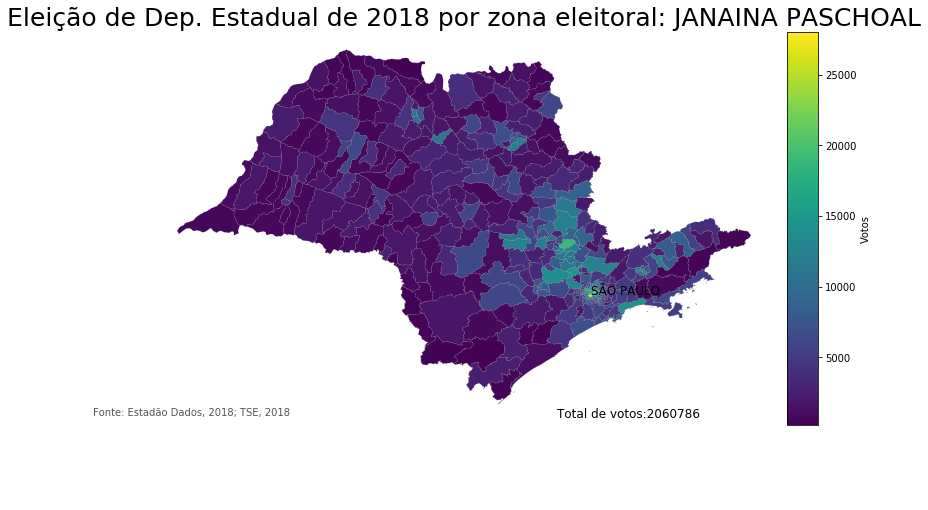

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(12,12))

df_mapa_cand["center"] = df_mapa_cand["geometry"].centroid
df_points = df_mapa_cand.copy()
df_points.set_geometry("center", inplace = True)

for x, y, label in zip(df_points[:1].geometry.x, df_points[:1].geometry.y, df_points[:1]['FIRST_sede']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = df_mapa_cand.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': "Votos", 'orientation': "vertical"}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')
ax.set_axis_off()
ax.set_title('Eleição de Dep. Estadual de 2018 por zona eleitoral: '+ df_mapa_cand['NM_URNA_CANDIDATO'].iloc[0], fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Total de votos:' + str(df_mapa_cand['QT_VOTOS_NOMINAIS'].sum()), xy=(0.6,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12)
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')
plt.show()
fig.savefig('sp-estado-'+ str(df_candidato['NR_CANDIDATO'].iloc[0]) +'.png')

## Ranking das zonas eleitorais mais e menos votados

In [14]:
ranking = df_mapa_cand[['FIRST_NOME','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False).reset_index()
ranking['%'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100
ranking.rename(columns = {'index':'Zona'}, inplace = True)

In [15]:
ranking.head()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
0,239,SÃO PAULO - INDIANÓPOLIS,28020,1.359675
1,234,SÃO PAULO - TATUAPÉ,24010,1.165089
2,5,SÃO PAULO - VILA MARIANA,20442,0.991952
3,3,SÃO PAULO - MOÓCA,20264,0.983314
4,255,CAMPINAS,19029,0.923386


In [16]:
ranking.tail()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
388,216,ESTRELA D'OESTE,409,0.019847
389,154,PAULO DE FARIA,388,0.018828
390,202,MIRACATU,367,0.017809
391,9,APIAÍ,343,0.016644
392,140,ELDORADO,216,0.010481


# Definir partido para analisar

In [19]:
# Definir partido para analisar
NR_PARTIDO = 13

In [20]:
df_part = df_concat[df_concat['NR_PARTIDO'] == NR_PARTIDO]
df_part_zona = df_part.groupby(['NR_ZONA', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS'].sum().reset_index()

## Exibir mapa da cidade de São Paulo

In [21]:
df_mapa_part = df_mapa.join(df_part_zona)
df_mapa_part.sort_values('QT_VOTOS_NOMINAIS', ascending=False, inplace=True)

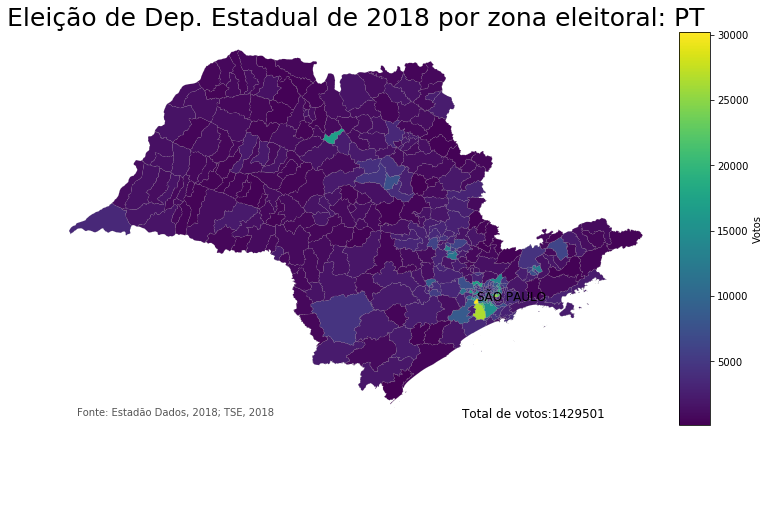

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(12,12))

df_mapa_part["center"] = df_mapa_part["geometry"].centroid
df_points = df_mapa_part.copy()
df_points.set_geometry("center", inplace = True)

for x, y, label in zip(df_points[:1].geometry.x, df_points[:1].geometry.y, df_points[:1]['FIRST_sede']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = df_mapa_part.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': "Votos", 'orientation': "vertical"}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')
ax.set_axis_off()
ax.set_title('Eleição de Dep. Estadual de 2018 por zona eleitoral: '+ df_mapa_part['SG_PARTIDO'].iloc[0], fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Total de votos:' + str(df_mapa_part['QT_VOTOS_NOMINAIS'].sum()), xy=(0.6,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12)
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')
plt.show()
fig.savefig('sp-estado-'+ df_part['SG_PARTIDO'].iloc[0] +'.png')

## Ranking das zonas eleitorais mais e menos votados

In [23]:
ranking = df_mapa_part[['FIRST_NOME','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False).reset_index()
ranking['%'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100
ranking.rename(columns = {'index':'Zona'}, inplace = True)

In [24]:
ranking.head()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
0,338,SÃO PAULO - PIRAPORINHA,30220,2.114024
1,347,SÃO PAULO - PARELHEIROS,26563,1.858201
2,341,SÃO PAULO - SÃO MATEUS,25544,1.786917
3,370,SÃO PAULO - CIDADE TIRADENTES,22870,1.599859
4,337,SÃO PAULO - GRAJAÚ,22690,1.587267


In [25]:
ranking.tail()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
388,95,POMPÉIA,248,0.017349
389,207,JUQUIÁ,245,0.017139
390,31,CAJURU,231,0.016159
391,43,DESCALVADO,207,0.014481
392,35,CANANÉIA,107,0.007485
